# 0 Descriptor of FL

We first introduce how we describe FL in our framework. We use the API ```flgo.init``` to create a federated runner to finish a run of FL, which is described as below:

```
def init(task: str, algorithm, option = {}, model=None, Logger: flgo.experiment.logger.BasicLogger = flgo.experiment.logger.simple_logger.SimpleLogger, Simulator: BasicSimulator=flgo.simulator.DefaultSimulator, scene='horizontal'):
    r"""
    Initialize a runner in FLGo, which is to optimize a model on a specific task (i.e. IID-mnist-of-100-clients) by the selected federated algorithm.
    :param
        task (str): the dictionary of the federated task
        algorithm (module || class): the algorithm will be used to optimize the model in federated manner, which must contain pre-defined attributions (e.g. algorithm.Server and algorithm.Client for horizontal federated learning)
        option (dict || str): the configurations of training, environment, algorithm, logger and simulator
        model (module || class): the model module that contains two methods: model.init_local_module(object) and model.init_global_module(object)
        Logger (class): the class of the logger inherited from flgo.experiment.logger.BasicLogger
        Simulator (class): the class of the simulator inherited from flgo.simulator.BasicSimulator
        scene (str): 'horizontal' or 'vertical' in current version of FLGo
    :return
        runner: the object instance that has the method runner.run()
    """
    ...
```

Each run of a federated training process aims to optimize a given **model** on a specific **task** by using an **algorithm** with some hyper-parameter (i.e. **option**) under a particular environment (e.g. **scene**, **hardware condition**).

The term **model** usually shares the same meaning with centralized ML. The term **task** describes how the datasets are distributed among clients and some task-specific configuration (e.g. the dataset information, the target). **Algorithm** is the used optimization strategy and **option** contains several running-time option like learning rate and the number of training rounds. The **hardware condition** is simulated by the **Simulator**. For example, different clients may have different computing power, network latency, communication bandwidth. Finally, the **scene** refers to the four main paradigm in FL: Horizontal FL, Vertical FL, Decentralized FL and Hierarchical FL, as shown in Figure 1. 

- **(a) Horizontal FL**: a server coordinates different clients to collaboratively train the model. Particularly, each clients owns different samples, and each sample is with full features and labels.
- **(b) Vertical FL**: an active party (i.e. label owner) coordinates other passive parties to improve the model performance for its local objective. Particularly, different parties own different dimensions of the feature of each sample, and different data owners will shares a set of the same sample IDs. 
- **(c) Hierarchical FL**: edge servers are responsible for coordinating their themselves clients, and a global server coordinates different edge servers to train the model.
- **(d) Decentralized FL**: clients directly communicates with other clients to collaboratively maintain a global model or improve their own local models under specific communication protocols (e.g. line, ring, full). 


![Figure_1](https://github.com/WwZzz/myfigs/blob/master/figure_scene_in_fl.png)

Finally, from the view of doing experiments, we add the term **Logger** to customizely log the variables of interest (e.g. model checkpoints, training-time performance). Some options of experiments (e.g. device, the number of processes) are also contained in the term **option**.

# 1 Option Configuration

The full options are shown as below

| Category         | Name                | Type      | Description                                                                                    | Default Value | Comment                                                                 |
|------------------|---------------------|-----------|------------------------------------------------------------------------------------------------|---------------|-------------------------------------------------------------------------|
|  **Training Option** | num_rounds          | int       | number of communication rounds                                                                 | 20            |                                                                         |
|                  | proportion          | float     | proportion of clients sampled per round                                                        | 0.2           |                                                                         |
|                  | learning_rate_decay | float     | learning rate decay for the training process                                                   | 0.998         | effective if lr_scheduler>-1                                            |
|                  | lr_scheduler        | int       | type of the global learning rate scheduler                                                     | -1            | effective if larger than -1                                             |
|                  | early_stop          | int       | stop training if there is no improvement  for no smaller than the maximum rounds               | -1            | effective if larger than -1                                             |
|                  | num_epochs          | int       | number of epochs of local training                                                             | 5             |                                                                         |
|                  | num_steps           | int       | number of steps of local training,  conflict with num_epochs                                   | -1            | dominates num_epochs if larger than 0                                   |
|                  | learning_rate       | float     | learning rate of local training                                                                | 0.1           |                                                                         |
|                  | batch_size          | int\float | batch size of local training                                                                   | 64            | -1 means full batch, float value  means the ratio of the full datasets  |
|                  | optimizer           | str       | to select the optimizer of local training                                                      | 'sgd'         | 'sgd','adam','rmsprop','adagrad'                                        |
|                  | clip_grad           | float     | clipping gradients if the max norm of  gradients \|\|g\|\| > clip_norm > 0                     | 0.0           | effective if larger than 0.0                                            |
|                  | momentum            | float     | momentum of local training                                                                     | 0.0           |                                                                         |
|                  | weight_decay        | float     | weight decay of local training                                                                 | 0.0           |                                                                         |
|                  | num_edge_rounds     | int       | number of edge rounds in hierFL                                                                | 5             | effective if scene is 'hierarchical'                                    |
|                  | algo_para           | int\list  | algorithm-specific hyper-parameters                                                            | []            | the order should be consistent with  the claim                          |
|                  | sample              | str       | to select sampling form                                                                        | 'uniform'     | 'uniform', 'md', 'full',  x+'_with_availability'                        |
|                  | aggregate           | str       | to select aggregation form                                                                     | 'other'       | 'uniform', 'weighted_com',  'weighted_scale', 'other'                   |
| **External Option**  | train_holdout       | float     | the rate of holding out the validation  dataset from all the local training datasets           | 0.1           |                                                                         |
|                  | test_holdout        | float     | the rate of holding out the validation  dataset from the testing datasets owned by  the server | 0.0           | effective if the server has  no validation data                         |
|                  | local_test          | bool      | the local validation data will be equally  split into validation and testing parts  if True    | False         |                                                                         |
|                  | seed                | int       | seed for all the random modules                                                                | 0             |                                                                         |
|                  | gpu                 | int\list  | GPU IDs and empty input means using CPU                                                        | []            |                                                                         |
|                  | server_with_cpu     | bool      | the model parameters will be stored in  the memory if True                                     | False         |                                                                         |
|                  | num_parallels       | int       | the number of parallels during communications                                                  | 1             |                                                                         |
|                  | num_workers         | int       | the number of workers of DataLoader                                                            | 0             |                                                                         |
|                  | pin_memory          | bool      | 1)pin_memory of DataLoader, and 2) load  data directly into memory                             | False         |                                                                         |
|                  | test_batch_size     | int       | the batch_size used in testing phase                                                           | 512           |                                                                         |
| **Simulator Option** | availability        | str       | to select client availability mode                                                             | 'IDL'         | 'IDL','YMF','MDF','LDF','YFF', 'HOMO','LN','SLN','YC'                   |
|                  | connectivity        | str       | to select client connectivity mode                                                             | 'IDL'         | 'IDL','HOMO'                                                            |
|                  | completeness        | str       | to select client completeness mode                                                             | 'IDL'         | 'IDL','PDU','FSU','ADU','ASU'                                           |
|                  | responsiveness      | str       | to select client responsiveness mode                                                           | 'IDL'         | 'IDL','LN','UNI'                                                        |
| **Logger Option**    | log_level           | str       | the level of logger                                                                            | 'INFO'        | 'INFO','DEBUG'                                                          |
|                  | log_file            | bool      | whether log to file and default  value is False                                                | False         |                                                                         |
|                  | no_log_console      | bool      | whether log to screen and default  value is True                                               | True          |                                                                         |
|                  | no_overwrite        | bool      | whether to overwrite the old result                                                            | False         |                                                                         |
|                  | eval_interval       | int       | evaluate every __ rounds;                                                                      | 1             |                                                                         |

# 2 Task Configuration

This section introduces the definition of a federated task and how to run algorihms on different tasks in our frameworks. A federated task is defined as **optimizing an objective on a given data distribution**. 

Concretely, **the objective** is defined by the dataset, the objective function, and the evaluation metrics, and each benchmark module is consist of these three terms. For example, the benchmark `flgo.benchmark.mnist_classification` requires a model to perform correct classification on hand written digits images, which is evaluated by the accuracy. 

On the other hand, the **data distribution** suggests how the data is distributed among participants. For example, each participent may owns data that is identically and independently sampled from a global dataset, which is called the i.i.d. case. In our framework, `Paritioner` is responsible for creating such data distributions.

In our framework, we use the configuration of `benchmark` and `partitioner` to generate federated tasks. We now take a example to show how to write configurations to generate different data distributions on the same given benchmark.

## Example: MNIST classification under different data distributions

Firstly, each config is of the type `dict` in python. The key 'benchmark' and 'partitioner' repsectively specify the information about the aforementioned benchmark and Partitioner.

Data root directory has successfully been changed to D:\Tool\jupyter
Task ./mnist_iid has been successfully generated.


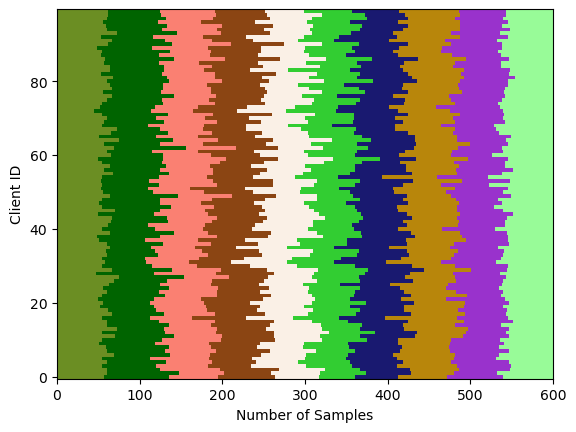

Task ./mnist_div01 has been successfully generated.


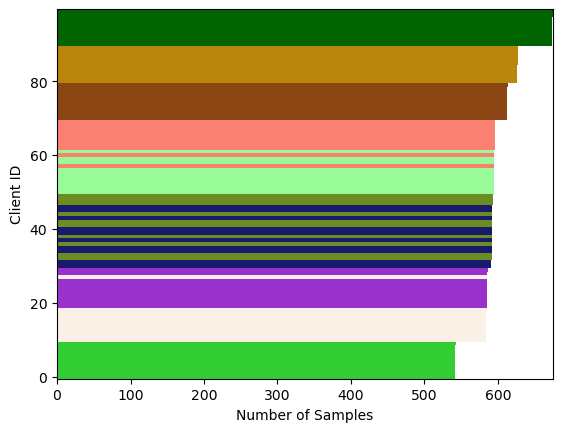

Task ./mnist_div05 has been successfully generated.


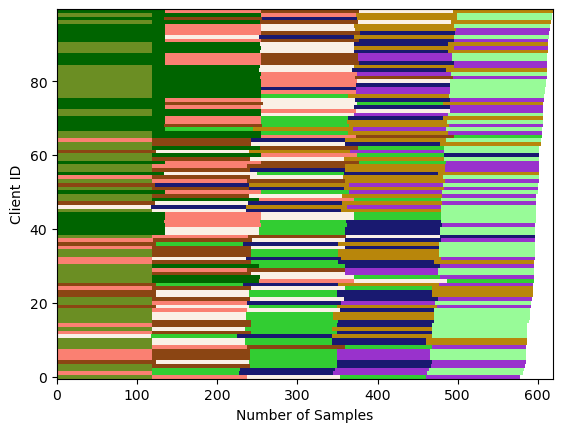

Task ./mnist_div09 has been successfully generated.


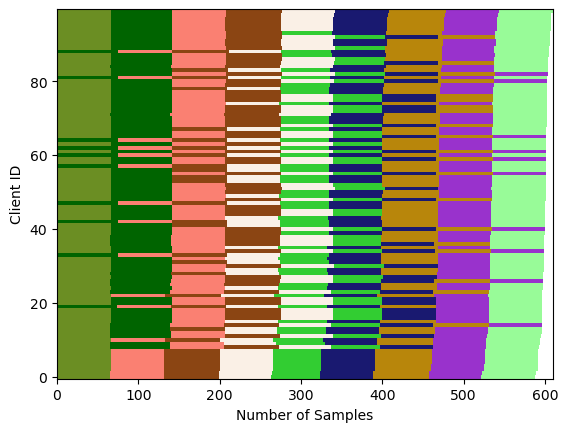

Error: 0.00458395
Error: 0.00350481
Error: 0.00301193
Error: 0.00221803
Error: 0.00215533
Error: 0.00181578
Error: 0.00179099
Error: 0.00134548
Error: 0.00134407
Error: 0.00128806
Error: 0.00091323
Error: 0.00079102
Error: 0.00078065
Error: 0.00065212
Error: 0.00062334
Error: 0.00054423
Error: 0.00018215
Error: 0.00003193
Error: 0.00002331
Error: 0.00001684
Error: 0.00001305
Error: 0.00001198
Error: 0.00000549
Error: 0.00000405
Error: 0.00000214
Error: 0.00000104
Task ./mnist_dir01 has been successfully generated.


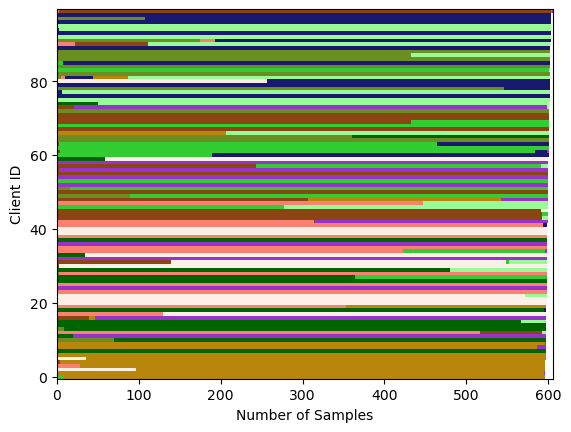

Error: 0.00164234
Error: 0.00129964
Error: 0.00115567
Error: 0.00089481
Error: 0.00079232
Error: 0.00049996
Error: 0.00043670
Error: 0.00042448
Error: 0.00027098
Error: 0.00024495
Error: 0.00009273
Error: 0.00002686
Error: 0.00002152
Error: 0.00000983
Error: 0.00000690
Error: 0.00000517
Error: 0.00000309
Error: 0.00000164
Error: 0.00000061
Task ./mnist_dir10 has been successfully generated.


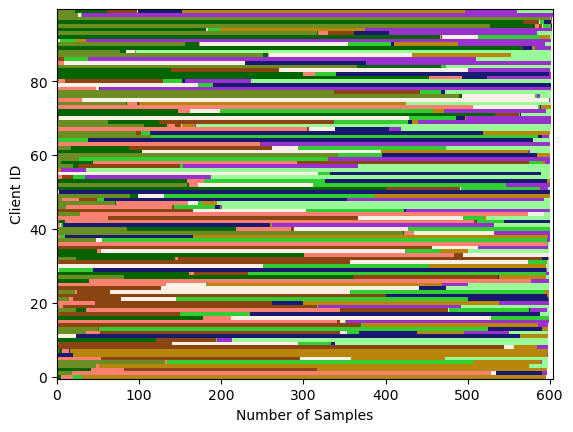

Error: 0.00192088
Error: 0.00183341
Error: 0.00163593
Error: 0.00157006
Error: 0.00145020
Error: 0.00138699
Error: 0.00126332
Error: 0.00118915
Error: 0.00097228
Error: 0.00088189
Error: 0.00073733
Error: 0.00072605
Error: 0.00051892
Error: 0.00046541
Error: 0.00023342
Error: 0.00020173
Error: 0.00019567
Error: 0.00012097
Error: 0.00009075
Error: 0.00006295
Error: 0.00004145
Error: 0.00002372
Error: 0.00001540
Error: 0.00000912
Error: 0.00000609
Error: 0.00000499
Error: 0.00000281
Error: 0.00000162
Task ./mnist_dir50 has been successfully generated.


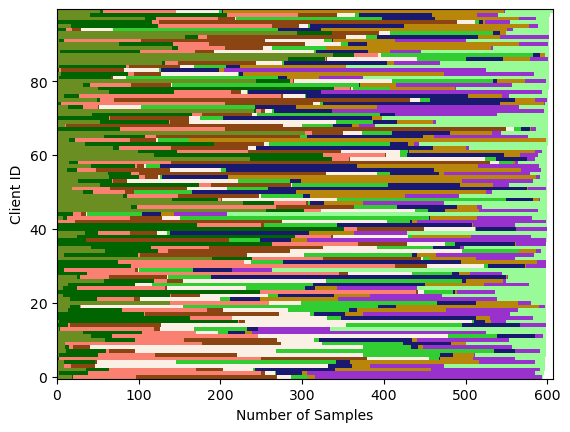

In [3]:
import flgo
flgo.set_data_root('cwd') # change the directory storing raw data to the current working directory
import flgo.benchmark.mnist_classification as mnist
import flgo.algorithm.fedavg as fedavg
import flgo.benchmark.partition
import os
# DiversityPartitioner will allocate the data to clients w.r.t. data diversity (e.g. here is label diversity)
# DirichletPartitioner will allocate the data to clients w.r.t. dirichlet distribution on specific attr. (e.g. here is also label)
config_iid = {'benchmark':mnist,'partitioner':{'name': flgo.benchmark.partition.IIDPartitioner,'para':{'num_clients':100}}}
config_div01 = {'benchmark':mnist,'partitioner':{'name': flgo.benchmark.partition.DiversityPartitioner,'para':{'num_clients':100, 'diversity':0.1}}}
config_div05 = {'benchmark':mnist,'partitioner':{'name': flgo.benchmark.partition.DiversityPartitioner,'para':{'num_clients':100, 'diversity':0.5}}}
config_div09 = {'benchmark':mnist,'partitioner':{'name': flgo.benchmark.partition.DiversityPartitioner,'para':{'num_clients':100, 'diversity':0.9}}}
config_dir01 = {'benchmark':mnist,'partitioner':{'name': flgo.benchmark.partition.DirichletPartitioner,'para':{'num_clients':100, 'alpha':0.1}}}
config_dir10 = {'benchmark':mnist,'partitioner':{'name': flgo.benchmark.partition.DirichletPartitioner,'para':{'num_clients':100, 'alpha':1.0}}}
config_dir50 = {'benchmark':mnist,'partitioner':{'name': flgo.benchmark.partition.DirichletPartitioner,'para':{'num_clients':100, 'alpha':5.0}}}
task_dict = {
    './mnist_iid': config_iid,
    './mnist_div01': config_div01,
    './mnist_div05': config_div05,
    './mnist_div09': config_div09,
    './mnist_dir01': config_dir01,
    './mnist_dir10': config_dir10,
    './mnist_dir50': config_dir50,
}

for task in task_dict:
    if not os.path.exists(task):
        flgo.gen_task(task_dict[task], task)

Secondly, use FedAvg to optimize these tasks with the same hyper-parameters.

In [ ]:
import flgo.algorithm.fedavg as fedavg
option = {'gpu':0, 'num_rounds':20, 'num_epochs':1, 'learning_rate':0.1, 'batch_size':64, 'eval_interval':2}
runners = [flgo.init(task, fedavg, option) for task in task_dict]
for runner in runners:
    runner.run()

Thirdly, use `flgo.experiment.analyzer` to read the records and visuazlie the results.

In [ ]:
import flgo.experiment.analyzer as al
import matplotlib.pyplot as plt
div_recs = al.Selector({'task':[t for t in task_dict if 'iid' in t or 'div' in t], 'header':['fedavg']})

plt.subplot(221)
for task in div_recs.tasks:
    rec_list = div_recs.records[task]
    for rec in rec_list:
        plt.plot(rec.data['communication_round'], rec.data['test_accuracy'], label=task.split('/')[-1])
plt.title('testing accuracy - diversity')
plt.ylabel('test_accuracy')
plt.xlabel('communication round')
plt.legend()

plt.subplot(222)
for task in div_recs.tasks:
    rec_list = div_recs.records[task]
    for rec in rec_list:
        plt.plot(rec.data['communication_round'], rec.data['test_loss'], label=task.split('/')[-1])
plt.title('testing loss - diversity')
plt.ylabel('test_loss')
plt.xlabel('communication round')
plt.legend()

plt.subplot(223)
dir_recs = al.Selector({'task':[task for task in task_dict if 'iid' in task or 'dir' in task], 'header':['fedavg']})
for task in dir_recs.tasks:
    rec_list = dir_recs.records[task]
    for rec in rec_list:
        plt.plot(rec.data['communication_round'], rec.data['test_accuracy'], label=task.split('/')[-1])
plt.title('testing accuracy - Dirichlet')
plt.ylabel('test_accuracy')
plt.xlabel('communication round')
plt.legend()

plt.subplot(224)
dir_recs = al.Selector({'task':[task for task in task_dict if 'iid' in task or 'dir' in task], 'header':['fedavg']})
for task in dir_recs.tasks:
    rec_list = dir_recs.records[task]
    for rec in rec_list:
        plt.plot(rec.data['communication_round'], rec.data['test_loss'], label=task.split('/')[-1])
plt.title('testing loss - Dirichlet')
plt.ylabel('test_loss')
plt.xlabel('communication round')
plt.legend()
plt.show()